In [1]:
import tensorflow as tf 
import numpy as np
import matplotlib.pyplot as plt
from silence_tensorflow import silence_tensorflow
from preparing_data import *

%matplotlib inline
silence_tensorflow()

In [2]:
TRAINING_PATH = os.path.join(os.getcwd(), 'data/cats_and_dogs_filtered/train')
VALIDATION_PATH = os.path.join(os.getcwd(), 'data/cats_and_dogs_filtered/validation')
TEST_PATH = os.path.join(os.getcwd(), 'data/cats_and_dogs_filtered/test')

In [3]:
aux = data_counter(VALIDATION_PATH, 'Validation')
aux = data_counter(TRAINING_PATH, 'Training')

Number of files in Validation is 600
Number of files in Training is 2000


In [11]:
split_test_val(test_path=VALIDATION_PATH, validation_path=TEST_PATH, split_size=0.4)

In [4]:
aux = data_counter(TEST_PATH, 'Test')
aux = data_counter(VALIDATION_PATH, 'Validation')
aux = data_counter(TRAINING_PATH, 'Training')


Number of files in Test is 400
Number of files in Validation is 600
Number of files in Training is 2000


In [5]:
batch_s = 32
image_s = (256, 256)

training_data = tf.keras.utils.image_dataset_from_directory(directory=TRAINING_PATH,
                                                labels='inferred',
                                                label_mode='binary',
                                                color_mode='rgb',
                                                shuffle=True,
                                                batch_size=batch_s,
                                                image_size=image_s)

validation_data = tf.keras.utils.image_dataset_from_directory(directory=VALIDATION_PATH,
                                                labels='inferred',
                                                label_mode='binary',
                                                color_mode='rgb',
                                                shuffle=False,
                                                batch_size=batch_s,
                                                image_size=image_s)

test_data = tf.keras.utils.image_dataset_from_directory(directory=TEST_PATH,
                                                labels='inferred',
                                                label_mode='binary',
                                                color_mode='rgb',
                                                shuffle=False,
                                                batch_size=1,
                                                image_size=image_s)

                                        
assert training_data.class_names == validation_data.class_names == test_data.class_names

Found 2000 files belonging to 2 classes.
Found 600 files belonging to 2 classes.
Found 400 files belonging to 2 classes.


In [6]:
names = training_data.class_names
names

['cats', 'dogs']

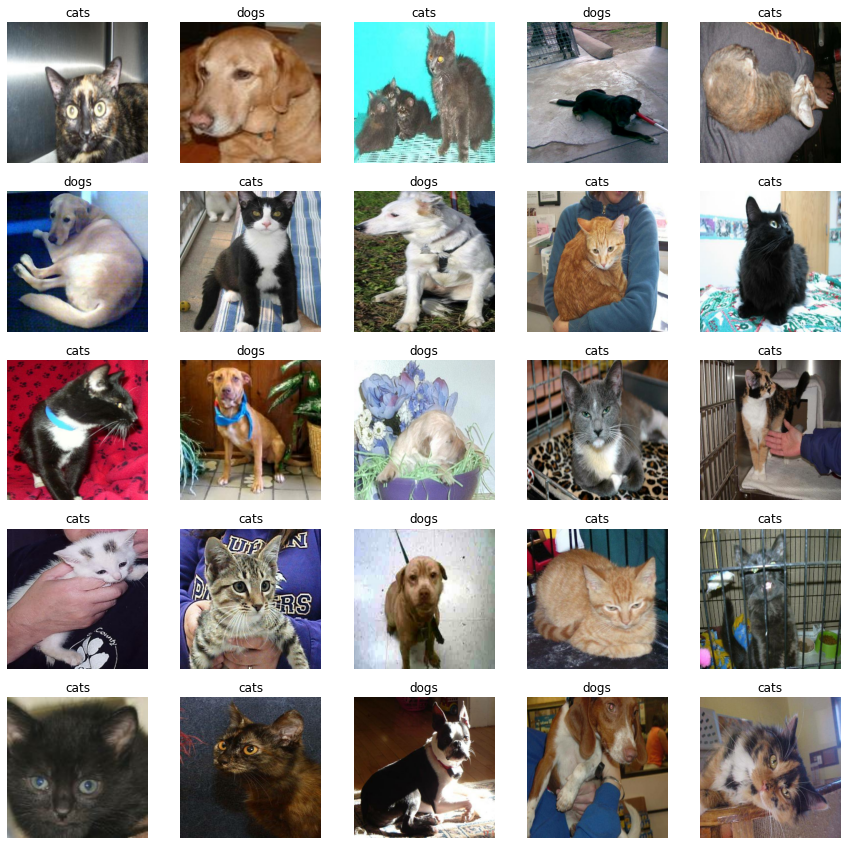

In [7]:
training_samples = list(training_data.take(1).as_numpy_iterator())

# print(training_samples.shape)
plt.figure(figsize=(15,15))
for image, label in training_samples:
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(image[i].astype('uint8'))
        plt.title(names[label[i][0].astype('uint8')])
        plt.axis('off')

In [9]:
from keras import Sequential, Model
from tensorflow.keras.layers import Rescaling, RandomRotation, RandomContrast, RandomFlip, RandomZoom

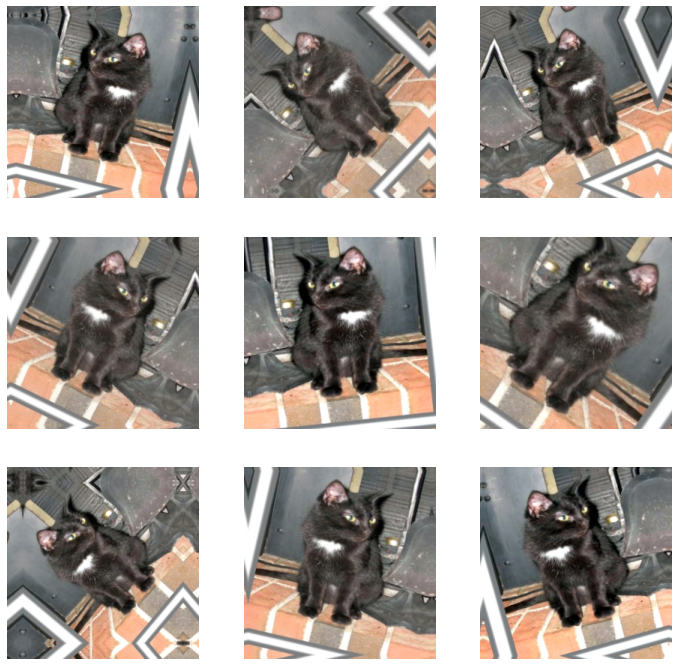

In [10]:
data_augumentation = Sequential([
    RandomRotation(0.15),
    RandomFlip('horizontal'),
    RandomContrast(factor=(0.1, 0.5)),
    RandomZoom(0.2),
])

plt.figure(figsize=(12,12))
for image, label in training_data.take(1):
    for i in range(9):
        augumented = data_augumentation(image)
        ax = plt.subplot(3,3, i+1)
        plt.imshow(augumented[0].numpy().astype('uint8'))
        plt.axis('off')

In [11]:
from keras import Input
from keras.layers import Dense, Flatten, Dropout
from keras.callbacks import ModelCheckpoint

In [13]:
def create_model():
    inpt = Input(shape=(256, 256, 3))
    x = Rescaling(scale=1./255)(inpt)
    x = data_augumentation(x, training=True)
    x = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(include_top=False, weights='imagenet')(x)
    x = Flatten()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(1, activation='sigmoid')(x)

    model = Model(inpt, x)
    return model


os.makedirs(os.path.join(os.getcwd(), 'saved_models/cats_dogs/'))
cats_dogs_checkpoint = os.path.join(os.getcwd(), 'saved_models/cats_dogs/cp.cpkt')

checkpoint = ModelCheckpoint(filepath=cats_dogs_checkpoint,
                             monitor='val_accuracy',
                             save_best_only=True,
                             mode='max',
                             save_freq='epoch',
                             save_weights_only=True,
                             verbose=2)

In [14]:
inception_resnet = create_model()
inception_resnet.compile(optimizer='adam',
                         loss='binary_crossentropy',
                         metrics=['accuracy'])

with tf.device('/gpu:0'):
    history = inception_resnet.fit(training_data,
                                   epochs=20,
                                   validation_data=validation_data,
                                   callbacks = [checkpoint])

Epoch 1/20
63/63 [==============================] - ETA: 0s - loss: 2.1152 - accuracy: 0.8265
Epoch 1: val_accuracy improved from -inf to 0.73167, saving model to /home/barti/deep/tenorflow-projects/saved_models/cats_dogs/cp.cpkt
63/63 [==============================] - 56s 649ms/step - loss: 2.1152 - accuracy: 0.8265 - val_loss: 53.3180 - val_accuracy: 0.7317
Epoch 2/20
63/63 [==============================] - ETA: 0s - loss: 0.6294 - accuracy: 0.8865
Epoch 2: val_accuracy did not improve from 0.73167
63/63 [==============================] - 35s 561ms/step - loss: 0.6294 - accuracy: 0.8865 - val_loss: 201.7328 - val_accuracy: 0.4600
Epoch 3/20
63/63 [==============================] - ETA: 0s - loss: 0.2202 - accuracy: 0.9190
Epoch 3: val_accuracy improved from 0.73167 to 0.81167, saving model to /home/barti/deep/tenorflow-projects/saved_models/cats_dogs/cp.cpkt
63/63 [==============================] - 40s 629ms/step - loss: 0.2202 - accuracy: 0.9190 - val_loss: 1.1963 - val_accuracy: 

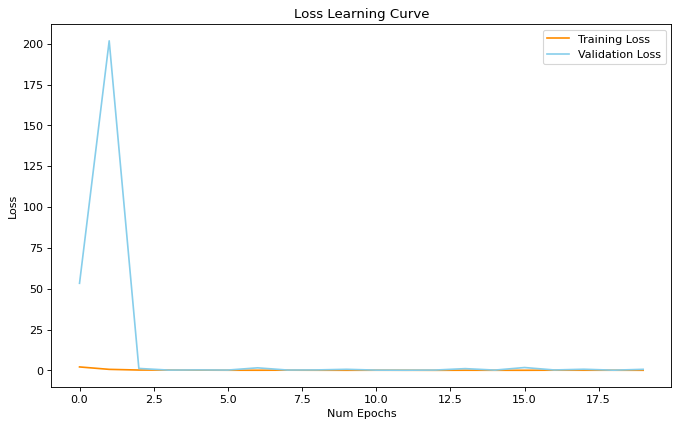

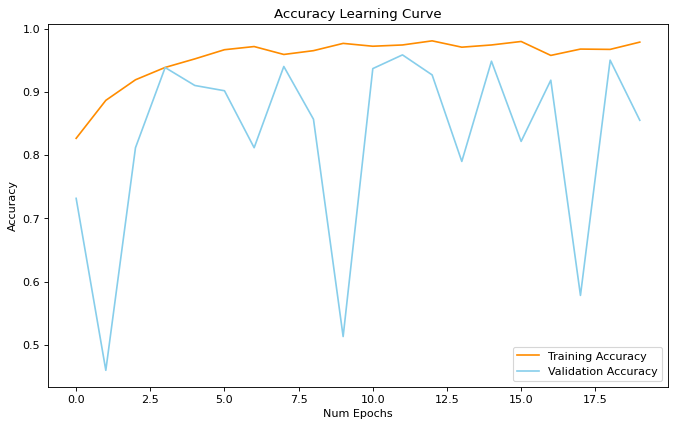

In [15]:
plot_learning(history, 'loss', 'val_loss', xtitle='Num Epochs', ytitle='Loss', plot_title='Loss Learning Curve', label_1='Training Loss', label_2='Validation Loss')
plot_learning(history, 'accuracy', 'val_accuracy', 'Num Epochs', 'Accuracy', plot_title='Accuracy Learning Curve', label_1='Training Accuracy', label_2='Validation Accuracy')

In [17]:
inception_resnet.load_weights(cats_dogs_checkpoint)
inception_resnet.evaluate(test_data)

400/400 [==============================] - 12s 29ms/step - loss: 0.0556 - accuracy: 0.9775


[0.055558208376169205, 0.9775000214576721]

Model scores 97.75% on previously unseen data.

In [18]:
from sklearn.metrics import classification_report

In [23]:
plt.figure(figsize=(20, 20))

test_list = list(test_data.as_numpy_iterator())

i = 0
for image, label in random.sample(test_list, 25):
    prediction = np.argmax(inception_resnet.predict(image, verbose=0))
    title = f"Predicted:{names[prediction]}\nReal: {str(names[label[0]])}"
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(image[0][0].astype('uint8'))
    plt.title(title)
    plt.axis('off')
    i+=1

TypeError: only integer scalar arrays can be converted to a scalar index

<Figure size 1440x1440 with 0 Axes>